# Loading Data

## Local csv file

In [1]:
region_mapping_df = spark.read.csv('data/state_region_map.csv', header=True)

## Local parquet file

In [2]:
disease_df = spark.read.parquet('data/chronic_disease_indicators')

In [3]:
disease_df.rdd.getNumPartitions()

4

## [Parquet file from s3]

We first we need to add hadoop-aws and aws-java-sdk jars

1. Download for proper version of hadoop and java you have installed
2. Link them to venv_spark_workshop/lib/python3.7/site-packages/pyspark/jars
3. Set up your aws credentials by exporting AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY
4. Debug... this can be a challenge and might be easier if you setup pyspark yourself rather than installing with pip

In [4]:
# public_finance_data = spark.read.csv('s3a://deutsche-boerse-xetra-pds/2019-02-24', header=True)

# Summarizing Data

__If our data doesn't fit in memory, how do we get a sense for what's in it?__

Spark data frame documentation: https://spark.apache.org/docs/2.4.0/api/python/pyspark.sql.html

In [5]:
import pyspark.sql.functions as F

## Looking at subsets of the data

Get the first(ish) row as a dictionary

In [6]:
disease_df.head().asDict()

{'YearStart': '2013',
 'YearEnd': '2013',
 'LocationAbbr': 'VA',
 'LocationDesc': 'Virginia',
 'DataSource': 'BRFSS',
 'Topic': 'Tobacco',
 'Question': 'Current smokeless tobacco use among adults aged >= 18 years',
 'Response': None,
 'DataValueUnit': '%',
 'DataValueType': 'Age-adjusted Prevalence',
 'DataValue': '5.1',
 'DataValueAlt': '5.1',
 'DataValueFootnoteSymbol': None,
 'DatavalueFootnote': None,
 'LowConfidenceLimit': '4.4',
 'HighConfidenceLimit': '6',
 'StratificationCategory1': 'Race/Ethnicity',
 'Stratification1': 'White, non-Hispanic',
 'StratificationCategory2': None,
 'Stratification2': None,
 'StratificationCategory3': None,
 'Stratification3': None,
 'GeoLocation': '(37.54268067400045, -78.45789046299967)',
 'ResponseID': None,
 'LocationID': '51',
 'TopicID': 'TOB',
 'QuestionID': 'TOB2_2',
 'DataValueTypeID': 'AGEADJPREV',
 'StratificationCategoryID1': 'RACE',
 'StratificationID1': 'WHT',
 'StratificationCategoryID2': None,
 'StratificationID2': None,
 'Stratificat

Show first 20 rows with formatting (only use with few columns)

In [7]:
region_mapping_df.show()

+--------------------+----------+---------+------------------+
|               State|State Code|   Region|          Division|
+--------------------+----------+---------+------------------+
|              Alaska|        AK|     West|           Pacific|
|             Alabama|        AL|    South|East South Central|
|            Arkansas|        AR|    South|West South Central|
|             Arizona|        AZ|     West|          Mountain|
|          California|        CA|     West|           Pacific|
|            Colorado|        CO|     West|          Mountain|
|         Connecticut|        CT|Northeast|       New England|
|District of Columbia|        DC|    South|    South Atlantic|
|            Delaware|        DE|    South|    South Atlantic|
|             Florida|        FL|    South|    South Atlantic|
|             Georgia|        GA|    South|    South Atlantic|
|              Hawaii|        HI|     West|           Pacific|
|                Iowa|        IA|  Midwest|West North C

In [8]:
sampled_df = disease_df.sample(withReplacement=False, fraction=0.001, seed=1199)

In [9]:
sampled_df.count()

5105

## Looking at simple aggregates of the data

In [10]:
disease_df.count()

519718

In [11]:
locations = disease_df.select("LocationAbbr").distinct().toPandas()

In [12]:
locations.head()

,LocationAbbr
0,AZ
1,SC
2,LA
3,MN
4,NJ


Lets look at frequency of topics by aggregating and collecting to Pandas

In [13]:
%%time
questions_per_topic = disease_df.groupby(
    'Topic'
).agg(
    F.countDistinct("QuestionID").alias('n_questions')
)

CPU times: user 5.92 ms, sys: 1.96 ms, total: 7.89 ms
Wall time: 37.5 ms


In [14]:
%%time
pd_questions_per_topic = questions_per_topic.toPandas()

CPU times: user 8.38 ms, sys: 2.58 ms, total: 11 ms
Wall time: 3.68 s


In [15]:
len(pd_questions_per_topic)

17

In [16]:
pd_questions_per_topic.set_index('Topic').sort_values('n_questions', ascending=False)

,n_questions
Topic,
"Nutrition, Physical Activity, and Weight Status",37
Diabetes,20
Cancer,20
Cardiovascular Disease,18
Chronic Obstructive Pulmonary Disease,16
Alcohol,16
Tobacco,16
Overarching Conditions,16
Arthritis,10


## Joining data frames

In [17]:
region_mapping_df.columns

['State', 'State Code', 'Region', 'Division']

In [52]:
disease_region_df = disease_df.join(
    region_mapping_df,
    on=disease_df['LocationAbbr']==region_mapping_df['State Code'],
    how='left_outer'
).select(
    disease_df['*'], region_mapping_df['Region'], region_mapping_df['Division']
)

In [53]:
disease_region_df.head()

Row(YearStart='2013', YearEnd='2013', LocationAbbr='VA', LocationDesc='Virginia', DataSource='BRFSS', Topic='Tobacco', Question='Current smokeless tobacco use among adults aged >= 18 years', Response=None, DataValueUnit='%', DataValueType='Age-adjusted Prevalence', DataValue='5.1', DataValueAlt='5.1', DataValueFootnoteSymbol=None, DatavalueFootnote=None, LowConfidenceLimit='4.4', HighConfidenceLimit='6', StratificationCategory1='Race/Ethnicity', Stratification1='White, non-Hispanic', StratificationCategory2=None, Stratification2=None, StratificationCategory3=None, Stratification3=None, GeoLocation='(37.54268067400045, -78.45789046299967)', ResponseID=None, LocationID='51', TopicID='TOB', QuestionID='TOB2_2', DataValueTypeID='AGEADJPREV', StratificationCategoryID1='RACE', StratificationID1='WHT', StratificationCategoryID2=None, StratificationID2=None, StratificationCategoryID3=None, StratificationID3=None, Region='South', Division='South Atlantic')

In [54]:
adjusted_binge_drinking_reponses = disease_region_df.filter(
    "QuestionID='ALC2_2' and StratificationCategoryID1='OVERALL' and DataValueTypeID='AGEADJPREV'"
)

In [60]:
division_label = 'Region'

In [61]:
binge_by_region = adjusted_binge_drinking_reponses.groupby(
    [division_label, 'YearStart']
).agg(
    F.mean('DataValue').alias('average_binge_drinking'),
    F.stddev_samp('DataValue').alias('std_binge_drinking'),
).toPandas()

In [62]:
binge_by_region.head()

,Region,YearStart,average_binge_drinking,std_binge_drinking
0,South,2013,14.758824,2.641983
1,None,2016,16.825000,2.956772
2,None,2012,16.766667,2.025669
3,South,2011,16.682353,3.262713
4,Northeast,2011,19.944444,0.765034


Get ready to plot by setting inline plotting!

In [63]:
%matplotlib inline

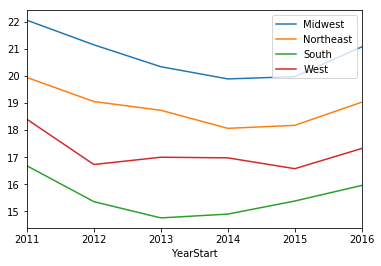

In [64]:
binge_by_region.set_index('YearStart').sort_index()\
    .groupby(division_label)\
    .average_binge_drinking.plot(legend=True);

In [35]:
tmp = region_mapping_df.toPandas()

In [40]:
tmp.Region.value_counts()

South        17
West         13
Midwest      12
Northeast     9
Name: Region, dtype: int64

In [41]:
tmp.Division.value_counts()

South Atlantic        9
Mountain              8
West North Central    7
New England           6
Pacific               5
East North Central    5
East South Central    4
West South Central    4
Middle Atlantic       3
Name: Division, dtype: int64

In [38]:
tmp

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific
5,Colorado,CO,West,Mountain
6,Connecticut,CT,Northeast,New England
7,District of Columbia,DC,South,South Atlantic
8,Delaware,DE,South,South Atlantic
9,Florida,FL,South,South Atlantic


In [37]:
tmp.query('Region=="South"')['State Code']

1     AL
2     AR
7     DC
8     DE
9     FL
10    GA
17    KY
18    LA
20    MD
25    MS
27    NC
36    OK
40    SC
42    TN
43    TX
45    VA
49    WV
Name: State Code, dtype: object